# Transversal Pump

The Hamiltonian is
$$
H_\text{trans} = \frac{p^2}{2m} + V_\text{ext}(x) - \hbar \Delta_\text{c} a^\dagger a + \hbar \eta \cos(kx) (a + a^\dagger) + \hbar U_0 \cos(kx)^2,
$$
where $\Delta_\text{c} = \omega_\text{l} - \omega_\text{c}$, $\eta$ is the pump strength and $U_0$ is the depth of the potential. Note that because $H_\text{trans} \propto \cos(kx) + \cos(kx)^2$, the Hamiltoninan is $\lambda$-periodic.

In [1]:
using QuantumOptics, PyPlot, Printf, LinearAlgebra

We choose a maximum number of photons of $N_\text{cutoff}=16$. If we choose $k=2\pi$, then $\lambda=1$.

In [9]:
# Define Parameters
N_cutoff = 64
xmin = 0
xmax = 1
Nsteps = 64

k = 2*π
ωr = 1

Δc = -10 * ωr
U0 = -1 * ωr;

In [10]:
# Bases
b_position = PositionBasis(xmin, xmax, Nsteps)
b_fock = FockBasis(N_cutoff)

# Operators for atom
p = momentum(b_position)

# Operators for cavity
a = destroy(b_fock) ⊗ one(b_position)
ad = dagger(a);

In [11]:
# Hamiltonian and calculate states
potential = x -> U0*cos(k*x)^2
H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
H_kin = (one(b_fock) ⊗ p^2) / k^2
H_cavity = -Δc*ad*a

function H(η)
    pump = x -> η*cos(k*x)
    H_pump = (one(b_fock) ⊗ potentialoperator(b_position, pump)) * (a + ad)
    return H_kin + dense(H_int) + H_pump + H_cavity
end;

In [12]:
# Plot distributions for first three states

rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")

η = 10 * ωr
E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);

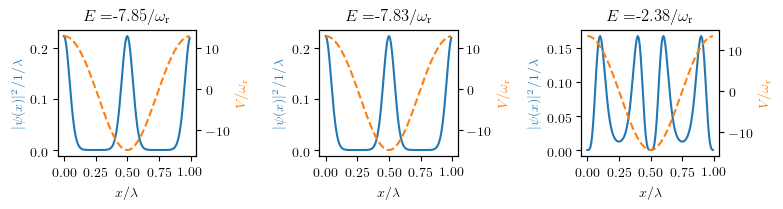

In [15]:
pygui(false)
N = real(expect(ad*a, ψ_states[1]))

xpoints = samplepoints(b_position)

fig = figure(figsize=(8, 2.2))
host_1 = fig.add_subplot(131)
host_2 = fig.add_subplot(132)
host_3 = fig.add_subplot(133)
hosts = [host_1, host_2, host_3]

for i in 1:3
    host = hosts[i]
    par1 = host.twinx()
    
    pos_dense = ptrace(ψ_states[i], 1)
    density = diag(pos_dense.data)
    ψ_sqr = abs2.(density)
    normalize!(ψ_sqr)
    ada_exp = expect(ad*a, ψ_states[i])
    apad_exp = 1.4 # From Qfunc
    pot = @. U0*cos(k*xpoints)^2*real(ada_exp) + η*cos(k*xpoints)*real(apad_exp)
    
#     host.set_ylim(-0.0004, 0.0078)
#     par1.set_ylim(-15.590715, 0.829001)
#     host.set_xlim(.25, .75)
#     par1.set_xlim(.25, .75)
    host.set_xticks([0, .25, .5, .75, 1])
    host.plot(xpoints, ψ_sqr, "C0")
    par1.plot(xpoints, pot, "C1", linestyle="--")
    
    host.set_xlabel(L"x / \lambda")
    host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
    par1.set_ylabel(L"V / \omega_\text{r}")
    host.yaxis.label.set_color("C0")
    par1.yaxis.label.set_color("C1")
    
#     par1.set_ylim(-7.370032, 0.350954)
    # Boundaries
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    
    title(L"E=" * @sprintf("%.2f", E[i]) * L"/ \omega_\text{r}")
end

tight_layout(rect=[0, 0, 1, 1])

We can see that the ground state and the first excited state have the same energy and thus are degenerate states. The peaks are higher than with longitudinal pumping.

In [6]:
# # Generate movie distributions for first three states

# using PyCall
# anim = pyimport("matplotlib.animation")

# rc("text", usetex=true)
# rc("text.latex", preamble= "\\usepackage{amsmath}")
# rc("font", family="serif")


# xpoints = samplepoints(b_position)

# fig = figure(figsize=(10, 2.5))

# function animate(η)
#     η *= ωr
#     E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);
    
#     clf()
#     host_1 = fig.add_subplot(131)
#     host_2 = fig.add_subplot(132)
#     host_3 = fig.add_subplot(133)
#     hosts = [host_1, host_2, host_3]

#     for i in 1:3
#         host = hosts[i]
#         par1 = host.twinx()

#         pos_dense = ptrace(ψ_states[i], 1)
#         density = diag(pos_dense.data)
#         ada_exp = expect(ad*a, ψ_states[i])
#         apad_exp = expect(a + ad, ψ_states[i])
#         pot = @. U0*cos(k*xpoints)^2*real(ada_exp) + η*cos(k*xpoints)*real(apad_exp)

#         host.set_ylim(-0.0000, 0.0007)
#         par1.set_ylim(-441.482335, 415.316547)
#         host.plot(xpoints, abs2.(density ./ sqrt(Nsteps)), "C0")
#         par1.plot(xpoints, pot, "C1", linestyle="--")

#         host.set_xlabel(L"x / \lambda, \eta=" * @sprintf("%d", η) * L"\omega_\text{r}")
#         host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
#         par1.set_ylabel(L"V / \omega_\text{r}")
#         host.yaxis.label.set_color("C0")
#         par1.yaxis.label.set_color("C1")

#         # Boundaries
#     #     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     #     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")

#         if i == 1
#             title("GS, " * L"E=" * @sprintf("%.2f", E[1]) * L"/ \omega_\text{r}")
#         elseif i == 2
#             title("1st exc, " * L"E=" * @sprintf("%.2f", E[2]) * L"/ \omega_\text{r}")
#         else
#             title("2nd exc, " * L"E=" * @sprintf("%.2f", E[3]) * L"/ \omega_\text{r}")
#         end
#     end

#     tight_layout()
# end

# etas = [0:1:100;]
# movie = anim.FuncAnimation(fig, animate, frames=etas, repeat=false, interval=80)
# movie.save("trans_variable_pump.mp4")

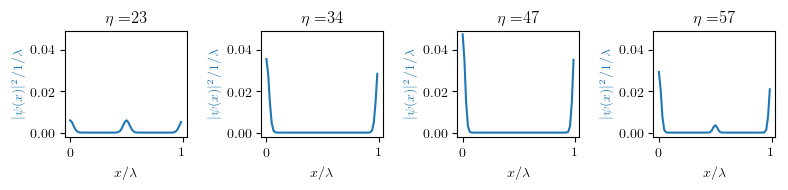

In [7]:
# Demonstrate limits of the numerical model

rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")
pygui(false)


xpoints = samplepoints(b_position)

fig = figure(figsize=(8, 2))

clf()
host_1 = fig.add_subplot(141)
host_2 = fig.add_subplot(142)
host_3 = fig.add_subplot(143)
host_4 = fig.add_subplot(144)
hosts = [host_1, host_2, host_3, host_4]

η_arr = [23, 34, 47, 57] .* ωr
# η_arr = [0:5:23;] .* ωr
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]
color_idx = 1

for i in 1:size(η_arr)[1]
    η = η_arr[i]
    E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);
        host = hosts[i]
        pos_dense = ptrace(ψ_states[1], 1)
        density = diag(pos_dense.data)
        host.set_ylim(-0.0020, 0.049)
        host.plot(xpoints, abs2.(density), "C0")
        host.set_xlabel(L"x / \lambda")
        host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
        host.yaxis.label.set_color("C0")

        # Boundaries
#         println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
    #     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    #     title(L"E=" * @sprintf("%.2f", E[i]) * L"/ \omega_\text{r}")
        host.title.set_text(L"\eta=" * @sprintf("%d", η))
end

tight_layout()



In [8]:
# Calculate momentum

b_momentum = MomentumBasis(b_position)
Tpx = transform(b_momentum, b_position)

η_arr = [0, 5, 10, 15] .* ωr
p_arr = []

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    pos_dense = ptrace(ψ_states[1], 1)
    states_p = Tpx * pos_dense
    momentum = abs.(diag(states_p.data))
    push!(p_arr, momentum)
end

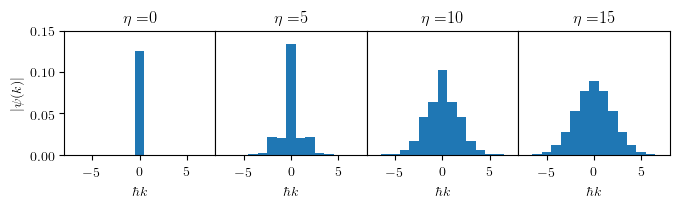

In [9]:
# Plot momentum

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

coeff_arr = [-Nsteps/2:1:Nsteps/2-1;]

fig = figure(figsize=(7,2.1875))
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
    
    host.bar(coeff_arr, p_arr[i], width=1)
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    host.set_ylim(0.0000, 0.15)
    host.set_xlim(-8, 8)
    host.set_xlabel(L"\hbar k")
    if i == 1
        host.set_ylabel(L"|\psi(k)|")
    else
        yticks([], [])
    end
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
end

# tight_layout(rect=[0, 0, 1.5, 1.6])
tight_layout()
subplots_adjust(hspace=0, wspace=0);

In [5]:
# Calculate parameters for photon number plot

η_arr = [0:0.5:15;] .* ωr
X = [0:1:N_cutoff;]
probab_arr = []
N_arr = []
σ_sqr_arr = []

for i in 1:size(η_arr)[1]
    _, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1)
    photon_dense = ptrace(ψ_states[1], 2)
    
    probab = diag(photon_dense.data)
    N = real(expect(ad*a, ψ_states[1]))
    σ_sqr = real(sum(probab .* X.^2) - N^2)
    
    push!(probab_arr, probab)
    push!(N_arr, N)
    push!(σ_sqr_arr, σ_sqr)
end

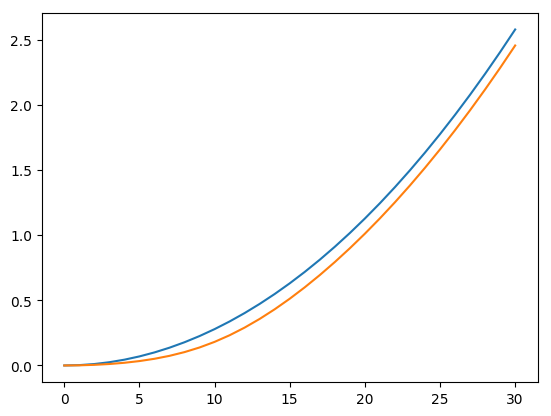

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3344ae940>

In [7]:
N_other = [0, 0.0027774977107312524, 0.011111208272029716, 0.025004784694994855, 0.04446431752945493, 0.06949833740898453, 0.100117817107542, 0.13633617159726308, 0.1781692541635204, 0.22563534620560471, 0.2787551379383685, 0.3375516968253934, 0.4020504202368414, 0.4722789685592864, 0.5482671748205172, 0.6300469268648772, 0.7176520182613177, 0.8111179644884796, 0.9104817815537585, 1.0157817250989631, 1.1270569892406077, 1.244347365888264, 1.3676928670552713, 1.4971333146670112, 1.6327079044954007, 1.7744547529840462, 1.9224104377250664, 2.0766095440385888, 2.2370842313124983, 2.4038638333212123, 2.576974506532628]
plot(N_other, "C0")
plot(N_arr, "C1")

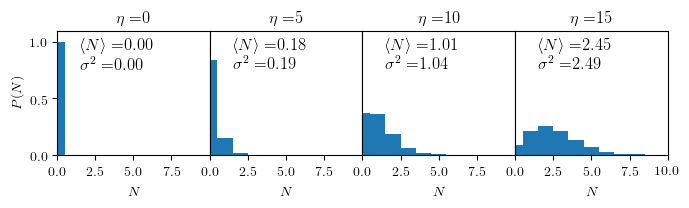

In [11]:
# Plot photon number
using PyCall

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

displace = [0.15, 0.15, 0.15, 0.15]

fig = figure(figsize=(7,2.1875))
# subplots(sharex=true)
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
    host.set_xlim(0, 10)
#     host.set_ylim(-0.0001, 0.0017)
    host.bar(X, probab_arr[i], width=1)
    host.set_xticks([0, 2.5, 5, 7.5])
    host.set_ylim(0, 1.1)
#     host.set_yticks([.25, .5, .75, 1])
    host.set_xlabel(L"N");
    
    if i == 1
        host.set_ylabel(L"P(N)")
    else
        yticks([], [])
    end
    
    if i == 4
        host.set_xticks([0, 2.5, 5, 7.5, 10])
    end

    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    
    textstr = L"\langle N \rangle=" * @sprintf("%.2f", real(N_arr[i])) * "\n" * L"\sigma^2=" * @sprintf("%.2f", σ_sqr_arr[i])
    host.text(displace[i], 0.95, textstr, transform=host.transAxes, fontsize=12, verticalalignment="top")
end
tight_layout()
subplots_adjust(hspace=0, wspace=0);
# text(-10.5, -.305, L"N");

Longitudinal and transversal photon number densities are the same.

In [5]:
# Calculate Qfunc

η_arr = [0, 7, 10, 15] .* ωr

# Boundary
bdr = 6
xvec = [-bdr:.1:bdr;]
yvec = [-bdr:.1:bdr;]
qfunc_arr = []

for i in 1:size(η_arr)[1]
    _, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    push!(qfunc_arr, abs.(husimi_q))
end

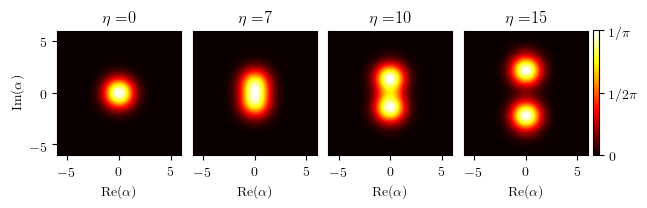

In [8]:
# Plot Qfunc
rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

colorz_0 = imshow(qfunc_arr[1], cmap="hot", interpolation="nearest", extent=(-6,6,-6,6))
clf()

fig = figure(figsize=(7,2.1875))
# fig = figure()
# gs = gridspec.GridSpec(1, size(η_arr)[1])

for i in 1:size(η_arr)[1]
#     host = fig.add_subplot(gs[0,i])
    
    plt_index = 100 + size(η_arr)[1] * 10 + i
    host = fig.add_subplot(plt_index)
    colorz = host.imshow(qfunc_arr[i], cmap="hot", interpolation="nearest", extent=(-6,6,-6,6))
    
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
#     host.set_xticks([-0.75, 0, 0.75])
    
    if i == 1
        ylabel(L"\mathrm{Im}(\alpha)")
        xlabel(L"\mathrm{Re}(\alpha)")
    else
        xlabel(L"\mathrm{Re}(\alpha)")
        yticks([], [])
    end
        
    colorbar_ticks = [0, 1/(2*π), 1/π]
    ticklabels = [L"0", L"1/2\pi", L"1/\pi"]
    
    if i < size(η_arr)[1]
        rez = fig.colorbar(cmap="hot", colorz, ticks=[], fraction=0.046, pad=0.04, filled=false, drawedges=true)
        rez.outline.set_color("white")
    else
        rez = fig.colorbar(cmap="hot", colorz_0, ticks=colorbar_ticks, fraction=0.046, pad=0.04)
        rez.set_ticklabels(ticklabels)
    end
    
        
end

subplots_adjust(hspace=0, wspace=0);
# tight_layout()

In [5]:
# Calculate order parameter

η_arr = [0:0.5:15;] .* ωr
bdr = 6
step = 0.1
len_half = bdr / step
xvec = [-bdr:step:bdr;]
yvec = [-bdr:step:bdr;]
order_param_arr = []

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    temp = abs(findmax(real.(husimi_q))[2][1] - (len_half + 1)) / len_half * bdr
    push!(order_param_arr, temp)
end

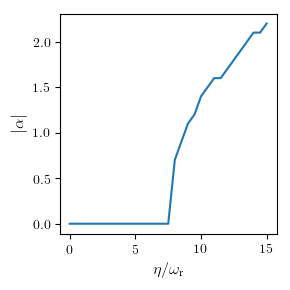

In [8]:
# Plot order parameter
rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")
pygui(false)

figure(figsize=(3,3))
plot(η_arr, order_param_arr)
xlabel(L"\eta / \omega_\text{r}", fontsize=12)
ylabel(L"|\alpha|", fontsize=12)
# xlim(0, 8)
tight_layout()
# title("Order parameter transversal")

There's clearly a threshold at which the order parameter starts to rise quickly.